In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

In [2]:
# Load the hash_master file
hash_df = pd.read_csv('../data/osstate/routes_hashes/hash_master.hash', header=None, names=['wpf', 'wpt', 'hash'])
print(f"There are {len(hash_df)} rows")
hash_df.head()

There are 38996 rows


,wpf,wpt,hash
0,yVYiw5LdGBHj,WtNfGYhU9NXD,f04422d69c87bf3e57775a2ab6f4_6f5
1,6CyC07jfLnnd,gjGUdQA4t348,f04422d69c87bf3e57775a2ab6f4_6f5
2,IejCrseQmSl7,op7JiDjB0ssO,e024375697c70f3417533aa637f4_6f5
3,BdqjF4kdoWuF,FEQqm0pwCiHB,06355708377841511e89a4d57999_8b3
4,Sqid2iRT6rsf,vcoAcE7pQ1gn,f04422569487bf3e57775a2ab6f4_6f5


In [3]:
hash_unique = hash_df['hash'].unique()
print('Number of unique hashes:', len(hash_unique))

Number of unique hashes: 65


In [4]:
# Rank the hashes by the number of times they appear
hash_counts = hash_df['hash'].value_counts()
hash_counts = hash_counts.sort_values(ascending=False)
hash_counts.head(10)


hash
0235571a176841711ec8a4c559dd_ffe    3485
8635571817e841751e89a4c579dd_8b3    3386
f04432569487bf3e57775a2ab7f4_6f5    3234
06355708377841511e89a4d57999_8b3    3064
f044a2d69c87bf3ed7775a2ab6f4_6f5    2646
06355708176841711e89a4c579d9_8b3    1896
8225571897e041751f09a4c779dd_8f3    1685
a225571e97c043751741a4877ddd_cf3    1642
06355718176841711e89a4c559dd_8b3    1627
8225571a97c041751f49a4c779dd_8f3    1572
Name: count, dtype: int64

In [5]:
# Load the waypoints_master file
wp_df = pd.read_csv('../data/osstate/waypoints_master.csv')
wp_df.head()

,ident,lat,lon
0,H882U2Xn5VOd,50.404884,-98.626030
1,P8ToOqoOwy3c,32.375521,130.663520
2,oZYSGKN80id2,41.086054,-77.855456
3,uPuRzZYavxw1,40.908554,-78.007263
4,lEf9PODPqPxe,40.573301,-78.509674


In [6]:
# df corresponding to the first hash value
hash_df1 = hash_df[hash_df['hash'] == hash_counts.index[2]]
print(f'There are {len(hash_df1)} rows for this hash pattern')
# sample randomly 100 rows
if len(hash_df1) > 100:
    hash_df1 = hash_df1.sample(100)
hash_df1.head()

There are 3234 rows for this hash pattern


,wpf,wpt,hash
22113,IKTGMeBTMXB8,O3WQwj5foK1X,f04432569487bf3e57775a2ab7f4_6f5
21555,ECMskenjglvh,aGTgpVXG8OqT,f04432569487bf3e57775a2ab7f4_6f5
22998,l7QW21nsR4Ex,mY95V5PFaO7o,f04432569487bf3e57775a2ab7f4_6f5
28563,6U31yYxyRhny,9hEGqkDRRXTu,f04432569487bf3e57775a2ab7f4_6f5
30277,xbfg9AFWiOF5,OekRBE9a7n2T,f04432569487bf3e57775a2ab7f4_6f5


In [7]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy


def plot_segments(hash_df, wp_df, globe=False, ax=None):
    
    # Create a Cartopy PlateCarree projection
    projection = ccrs.PlateCarree()

    # Create a figure and axis with the PlateCarree projection
    if ax is None:
        fig, ax = plt.subplots(subplot_kw={'projection': projection})

    # Get the waypoints
    wpf = hash_df['wpf'].values
    wpt = hash_df['wpt'].values

    # For each wpf, get the longitude and latitude
    for i in range(len(wpf)):
        wpf_lon = wp_df[wp_df['ident'] == wpf[i]]['lon'].values[0]
        wpf_lat = wp_df[wp_df['ident'] == wpf[i]]['lat'].values[0]
        wpt_lon = wp_df[wp_df['ident'] == wpt[i]]['lon'].values[0]
        wpt_lat = wp_df[wp_df['ident'] == wpt[i]]['lat'].values[0]

        # Plot the segment
        ax.plot([wpf_lon, wpt_lon], [wpf_lat, wpt_lat], 'b', transform=projection)


    # Add map features
    ax.coastlines()
    if not globe:
        # Only add the borders for non-global maps
        ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
    #ax.add_feature(cartopy.feature.LAND, edgecolor='black')
    #ax.add_feature(cartopy.feature.OCEAN)
    

    # Set the extent of the map
    if globe:
        ax.set_extent([-180, 180, -90, 90])

    # Show the plot
    if ax is None:
        plt.show()

# plot_segments(hash_df1, wp_df, globe=False)
# plot_segments(hash_df1, wp_df, globe=True)

In [8]:
def get_region_bounds(region: str) -> tuple:
    # Get the geographical boundaries for the map 
    if region=='conus':
        # Contiguous United States
        lat_bounds = [23, 51]
        lon_bounds = [-130, -65]
    elif region=='europe':
        # Europe, from Portugal to Greece, not including Russia
        lat_bounds = [34, 72]        
        lon_bounds = [-32, 40]
    else:
        raise ValueError(f"Region {region} not recognized. Use 'conus' or 'europe'.")
    
    return lat_bounds, lon_bounds

In [9]:
from tqdm import tqdm

def plot_all_flows(hash_counts: pd.DataFrame, hash_df: pd.DataFrame, wp_df: pd.DataFrame, n_rows = 5, n_cols = 5, globe = False, region = None) -> None:
    # Calculate the number of plots
    n_plots = n_rows * n_cols
    if n_plots > len(hash_counts):
        n_plots = len(hash_counts)
        n_rows = int(np.ceil(n_plots / n_cols))

    # Get the top n_plots hash values
    hash_values = hash_counts.head(n_plots).index

    # Create a figure
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 20), subplot_kw={'projection': ccrs.PlateCarree()})
    
    if region is not None:
        lat_bounds, lon_bounds = get_region_bounds(region)
        # Set the extent of the map
        for ax in axs.flatten():
            ax.set_extent([lon_bounds[0], lon_bounds[1], lat_bounds[0], lat_bounds[1]])

    # Plot the flows
    s = 0 # this is a variable to adjust the index for the plot since some plots will be skipped as they are irrelevant to the set region
    for i in tqdm(range(n_plots)):
        # Get the hash value
        hash_value = hash_values[i]

        # Get the data frame for this hash value
        hash_df_i = hash_df[hash_df['hash'] == hash_value]

        # If hash_df_i has more than 20 rows, sample 20 rows
        if len(hash_df_i) > 20:
            hash_df_i = hash_df_i.sample(20)
            
        # Skip this hash_value if the waypoints fall outside of the region
        if region is not None:
            wpf = hash_df_i['wpf'].values
            wpt = hash_df_i['wpt'].values
            # Only check the first wpf and wpt
            wpf_lon = wp_df[wp_df['ident'] == wpf[0]]['lon'].values[0]
            wpf_lat = wp_df[wp_df['ident'] == wpf[0]]['lat'].values[0]
            wpt_lon = wp_df[wp_df['ident'] == wpt[0]]['lon'].values[0]
            wpt_lat = wp_df[wp_df['ident'] == wpt[0]]['lat'].values[0]
            # If there is a single waypoint outside of the region, skip this hash value
            if not (lat_bounds[0] <= wpf_lat <= lat_bounds[1] and lon_bounds[0] <= wpf_lon <= lon_bounds[1] and
                    lat_bounds[0] <= wpt_lat <= lat_bounds[1] and lon_bounds[0] <= wpt_lon <= lon_bounds[1]):
                s += 1
                continue

        # Plot the segments
        plot_segments(hash_df_i, wp_df, globe=globe, ax=axs[(i-s) // n_cols, (i-s) % n_cols])

        # Add a title
        axs[(i-s) // n_cols, (i-s) % n_cols].set_title(f'Hash: {hash_value}')

    # Show the plot
    plt.tight_layout()
    plt.show()


In [18]:
from tqdm import tqdm

color_codes = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

def plot_all_flows_in_one_map(hash_counts: pd.DataFrame, hash_df: pd.DataFrame, wp_df: pd.DataFrame, n_first_hashes = 20, region = 'conus') -> None:

    # Get the top n_plots hash values
    hash_values = hash_counts.head(n_first_hashes).index
    
    # Create a Cartopy PlateCarree projection
    projection = ccrs.PlateCarree()

    # Create a figure
    fig, ax = plt.subplots(figsize=(20, 20), subplot_kw={'projection': ccrs.PlateCarree()})
    
    lat_bounds, lon_bounds = get_region_bounds(region)
    
    ax.set_extent([lon_bounds[0], lon_bounds[1], lat_bounds[0], lat_bounds[1]])

    # Plot the flows on one single unique map
    for i in tqdm(range(n_first_hashes)):
        # Get the hash value
        hash_value = hash_values[i]

        # Get the data frame for this hash value
        hash_df_i = hash_df[hash_df['hash'] == hash_value]

        # If hash_df_i has more than 20 rows, sample 20 rows
        if len(hash_df_i) > 20:
            hash_df_i = hash_df_i.sample(20)
            
        # Skip this hash_value if the waypoints fall outside of the region
        if region is not None:
            wpf = hash_df_i['wpf'].values
            wpt = hash_df_i['wpt'].values
            # Only check the first wpf and wpt
            wpf_lon = wp_df[wp_df['ident'] == wpf[0]]['lon'].values[0]
            wpf_lat = wp_df[wp_df['ident'] == wpf[0]]['lat'].values[0]
            wpt_lon = wp_df[wp_df['ident'] == wpt[0]]['lon'].values[0]
            wpt_lat = wp_df[wp_df['ident'] == wpt[0]]['lat'].values[0]
            # If there is a single waypoint outside of the region, skip this hash value
            if not (lat_bounds[0] <= wpf_lat <= lat_bounds[1] and lon_bounds[0] <= wpf_lon <= lon_bounds[1] and
                    lat_bounds[0] <= wpt_lat <= lat_bounds[1] and lon_bounds[0] <= wpt_lon <= lon_bounds[1]):
                continue

        # Get the waypoints
        wpf = hash_df_i['wpf'].values
        wpt = hash_df_i['wpt'].values

        # For each wpf, get the longitude and latitude
        color_of_hash = color_codes[i % len(color_codes)]
        for j in range(len(wpf)):
            wpf_lon = wp_df[wp_df['ident'] == wpf[j]]['lon'].values[0]
            wpf_lat = wp_df[wp_df['ident'] == wpf[j]]['lat'].values[0]
            wpt_lon = wp_df[wp_df['ident'] == wpt[j]]['lon'].values[0]
            wpt_lat = wp_df[wp_df['ident'] == wpt[j]]['lat'].values[0]

            # Plot the segment
            ax.plot([wpf_lon, wpt_lon], [wpf_lat, wpt_lat], transform=projection, label=f'hs:{hash_value}', color=color_of_hash)

    # Add map features
    ax.coastlines()
    # Add state borders
    ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
    plt.title(f'Top {n_first_hashes} flows for Contiguous United States identified by Zarya')
    plt.tight_layout()
    plt.show()


100%|██████████| 50/50 [01:14<00:00,  1.49s/it]


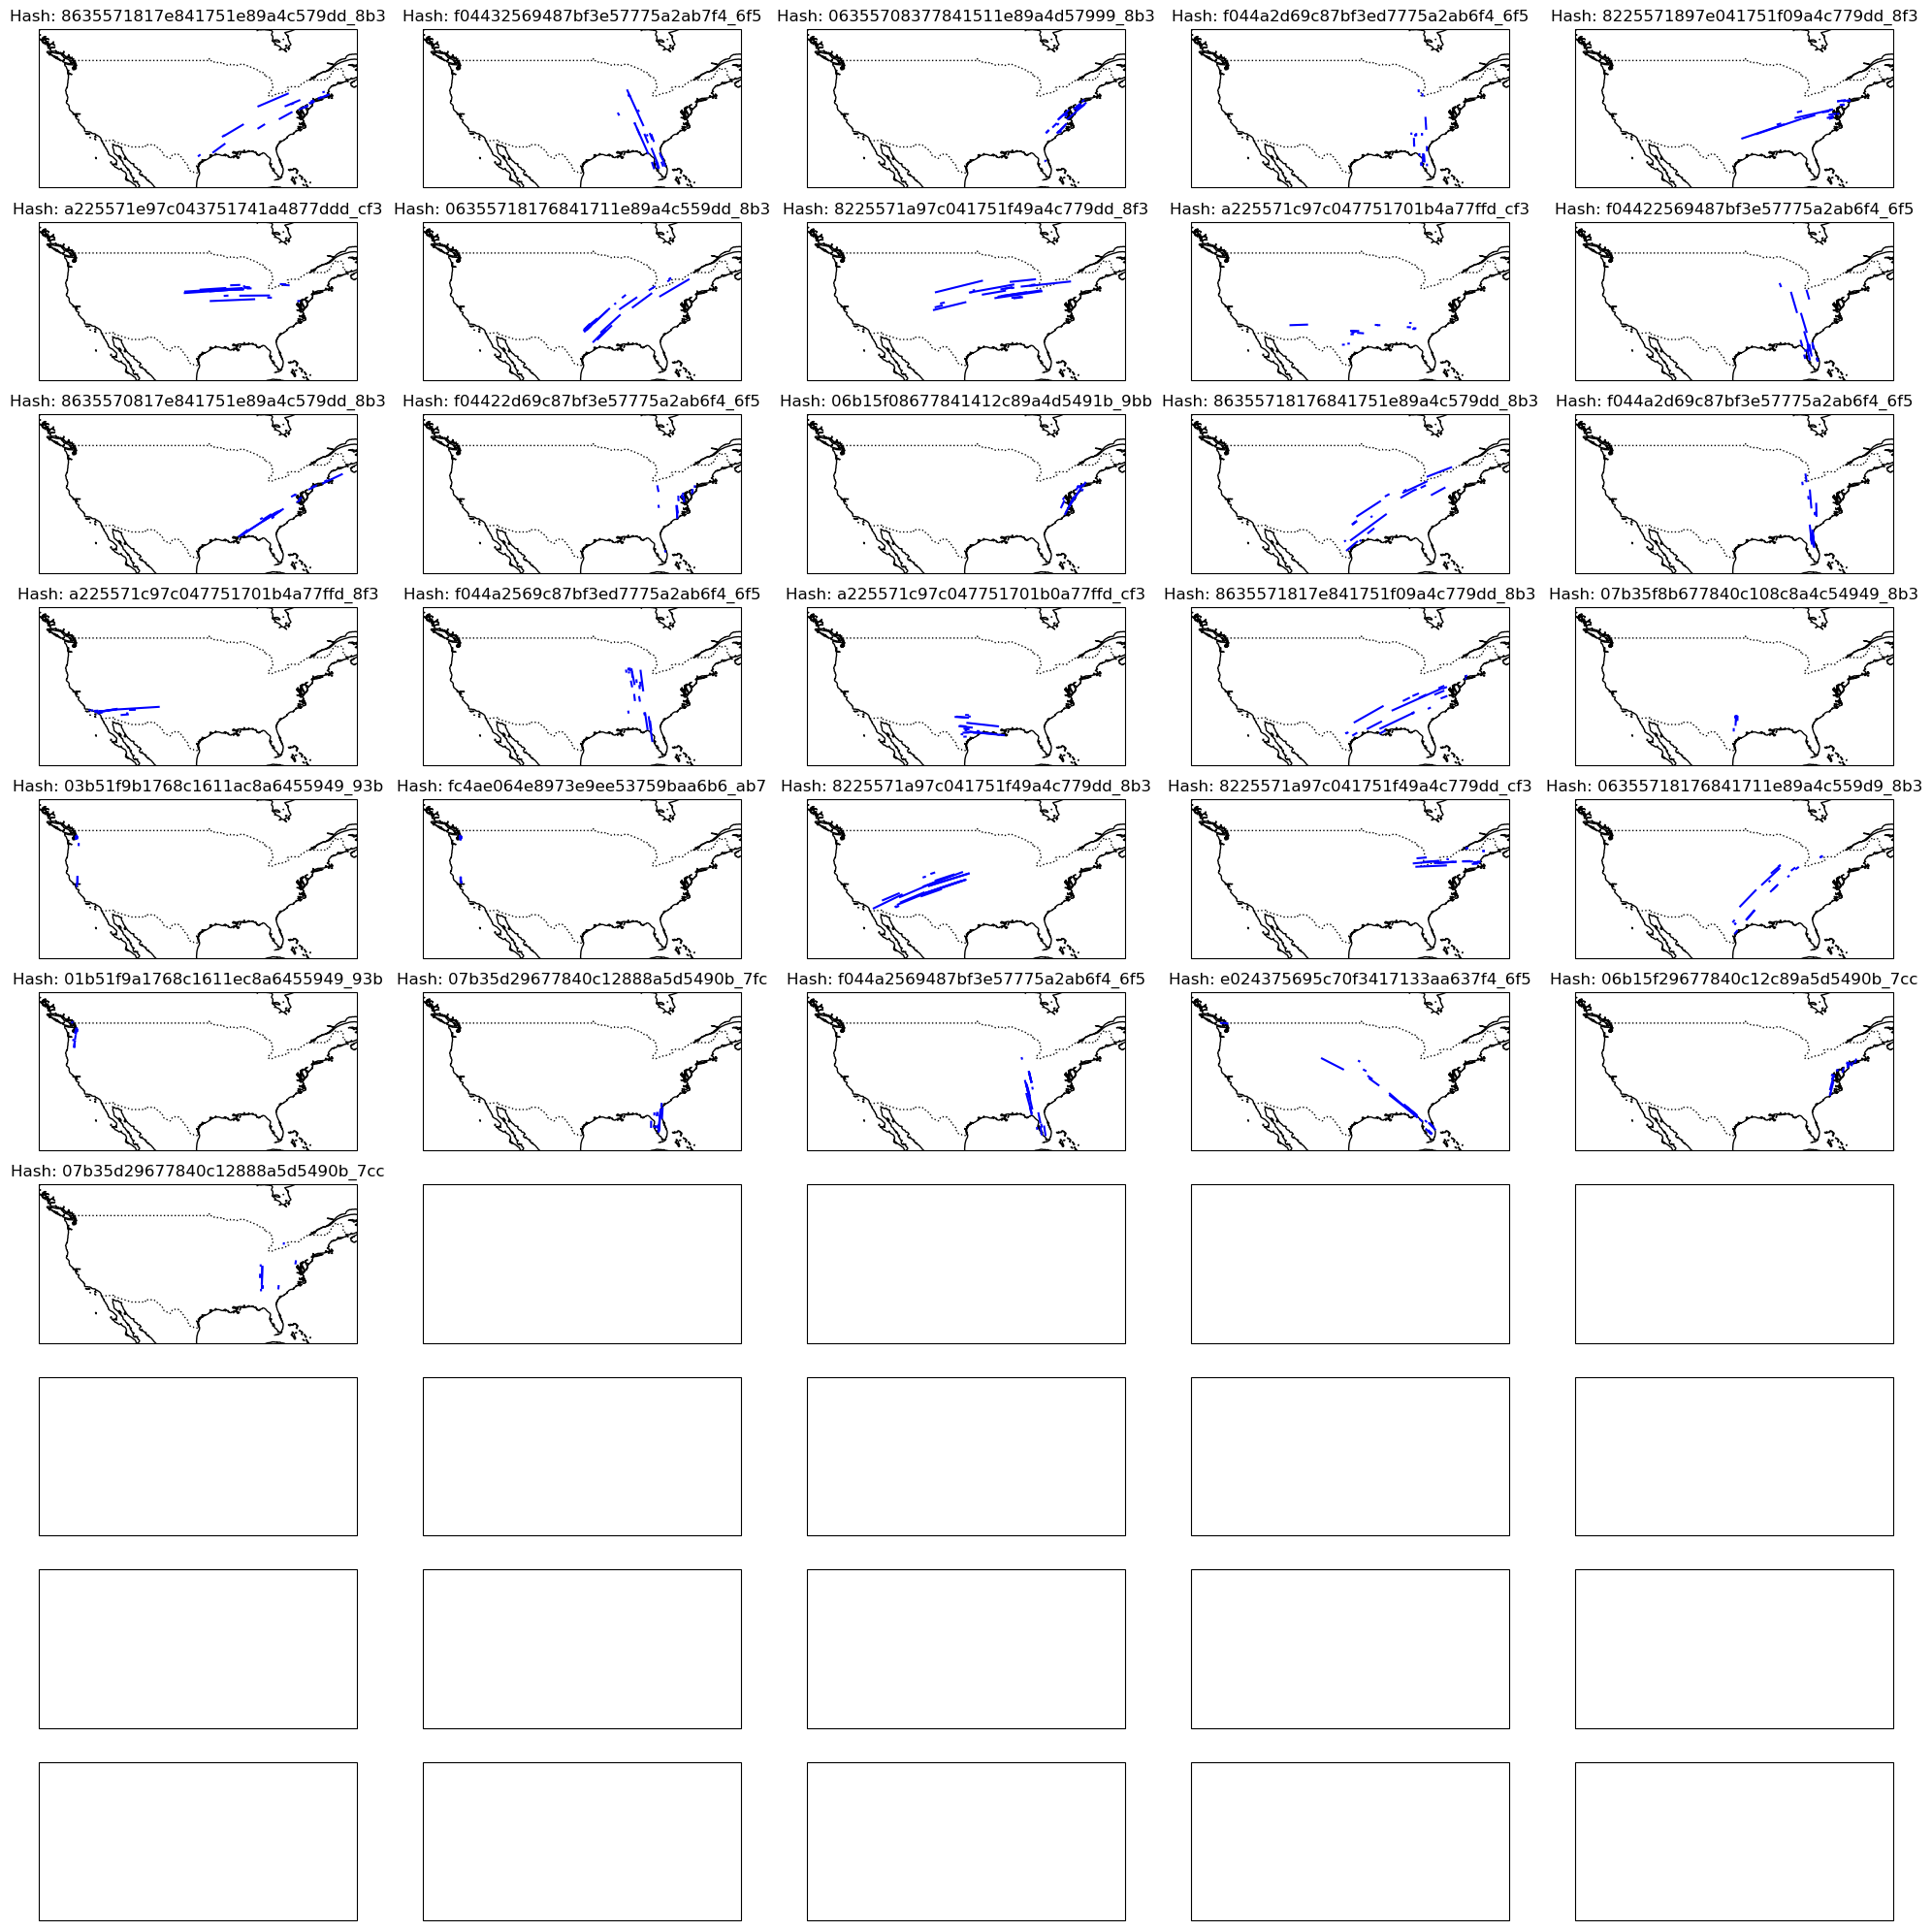

In [14]:
plot_all_flows(hash_counts, hash_df, wp_df, n_rows=10, n_cols=5, globe=False, region='conus')

  3%|▎         | 1/32 [00:00<00:04,  6.94it/s]

100%|██████████| 32/32 [00:45<00:00,  1.43s/it]


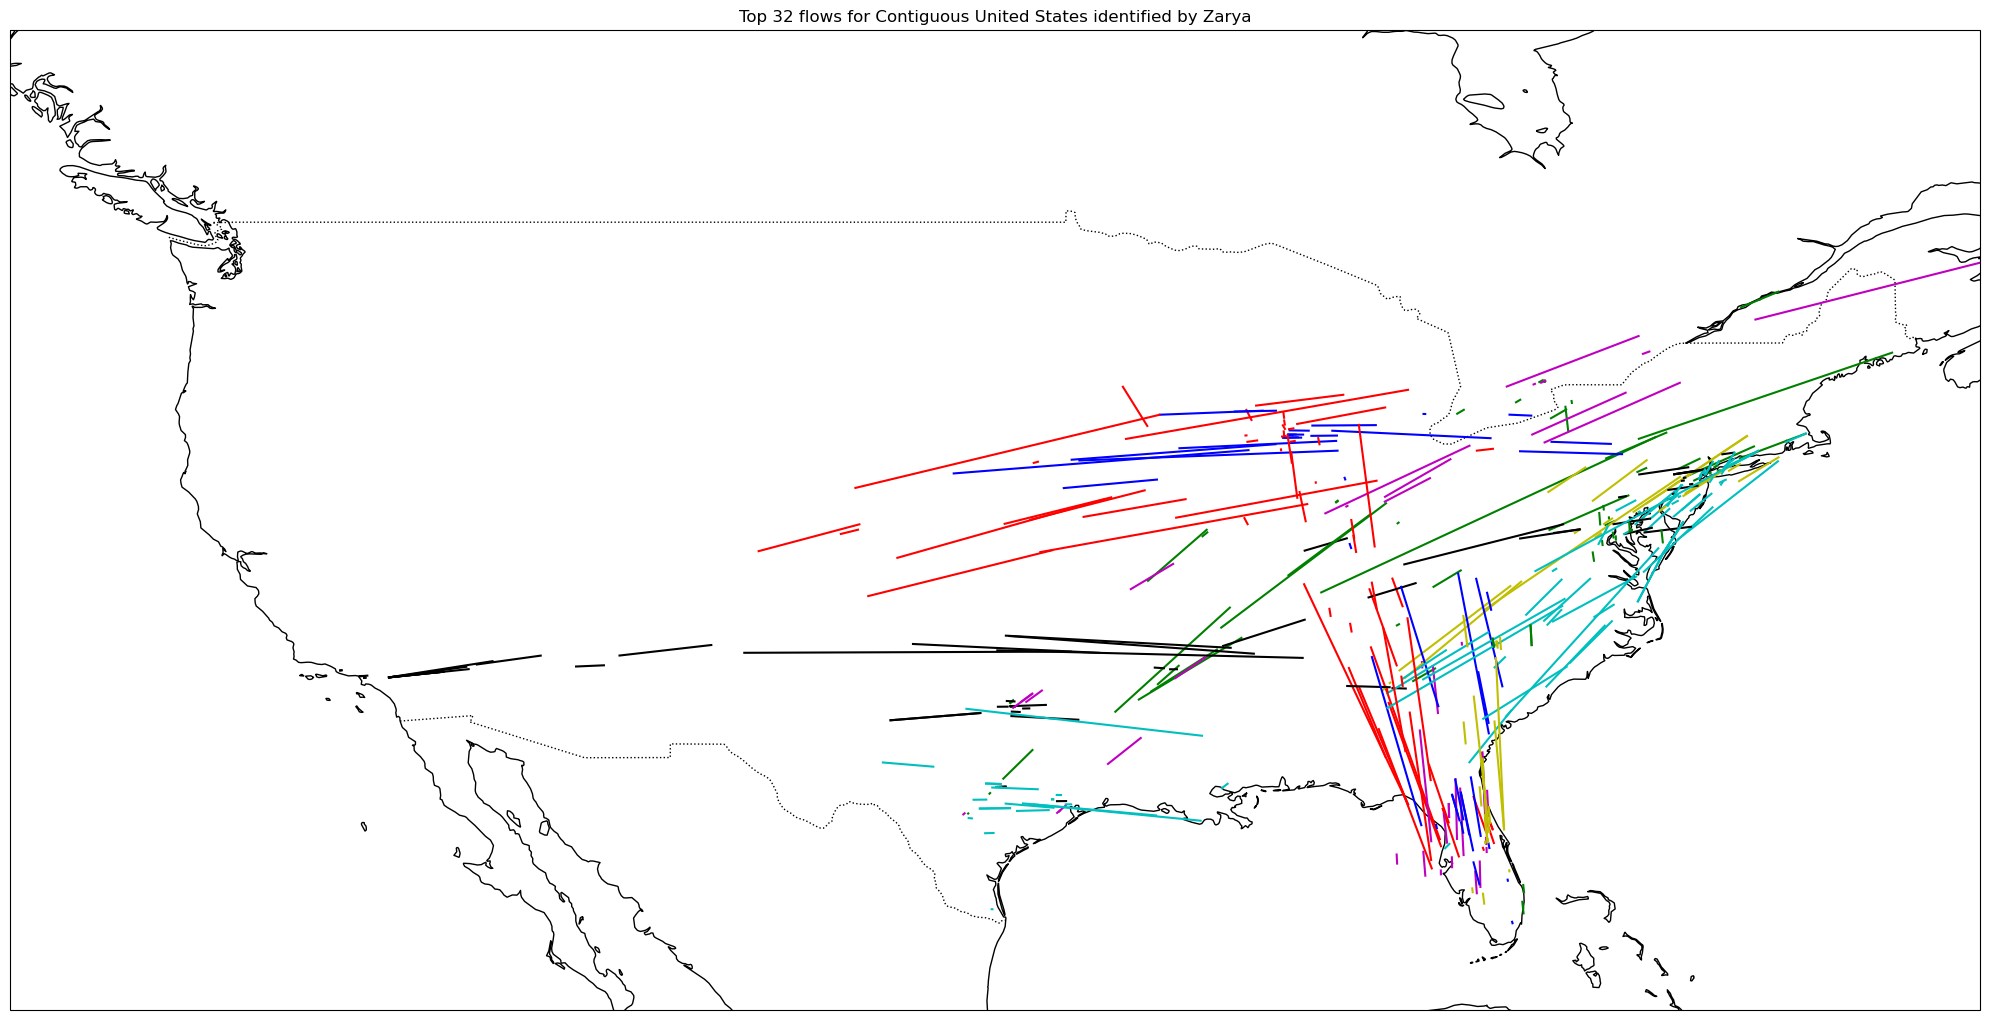

In [19]:
plot_all_flows_in_one_map(hash_counts, hash_df, wp_df, n_first_hashes=32, region='conus')